 # Automated Image Classification using Advanced Deep Learning Models
 The goal for this Lab is it to provide you understanding of the various deep learning models that we will be using in your project(s). In this Lab we will implement AlexNet Architecture over CUB200-2011 dataset:

 The CUB200-2011 dataset can be found on its [website](https://paperswithcode.com/dataset/cub-200-2011). We can either use the data zip file or import it using  [Kaggle](https://www.kaggle.com) and [kaggle-api](https://github.com/Kaggle/kaggle-api) which needs to be installed with `pip install kaggle`. I would prefer all of you do this using Google Colab. This will also help you with Last 3 Labs.

## Import Libraries and Set Random Seed

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

In [ ]:
# from zipfile import ZipFile
# file_name = ['/content/test - HSV.zip','/content/train - HSV.zip']
# for i in file_name:
#   with ZipFile(i, 'r') as z:
#     z.extractall()
#     print('Done')

 ## Data Preprocessing
 ### Downloading and extracting custom datasets


 ### Calculating the mean and std for normalization on custom datasets


 ### Loading transforms to augment and normalize our data

In [ ]:
train_path = '/content/train - HSV'
test_path = '/content/test - HSV'
classes = ['AnnualCrop','Forest','HerbaceousVegetation','Highway','Industrial','Pasture','PermanentCrop','Residential','River','SeaLake']

In [ ]:
from torchvision.transforms.transforms import CenterCrop
import cv2

class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return torchvision.transforms.functional.pad(image, padding, 0, 'constant')

##Recompute for each color spectrum
means = [0.348,0.384,0.411]
stds = [0.094,0.067,0.0566]

transform = torchvision.transforms.Compose(
    [
      SquarePad(),
      torchvision.transforms.RandomHorizontalFlip(p = 0.5),
      torchvision.transforms.RandomVerticalFlip(p = 0.5),
      torchvision.transforms.Resize(32),
      #torchvision.transforms.CenterCrop(224),
      #torchvision.transforms.RandomResizedCrop(224, (0.8, 1.0)),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(
          mean=means,
          std=stds
          )
    ]
)

train_data = torchvision.datasets.ImageFolder(
    root = train_path,
    transform = transform
)


train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size= 64,
    shuffle=True,
    num_workers=4
)

test_data = torchvision.datasets.ImageFolder(
    root = test_path,
    transform = transform
)


test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size= 64,
    shuffle=True,
    num_workers=4
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def normalize_image(image): 
  image_min = image.min() 
  image_max = image.max() 
  image.clamp_(min = image_min, max=image_max) 
  image.add_(-image_min).div_(image_max-image_min + 1e-5) 
  return image

In [ ]:
BATCH_SIZE = 256

train_iterator = data.DataLoader(train_data,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)
# valid_iterator = data.DataLoader(valid_data, batch_size = BATCH_SIZE)
test_iterator = data.DataLoader(test_data, batch_size = BATCH_SIZE)

 ## Defining a Convolutional Neural Network
 ### Defining the AlexNet blocks


In [ ]:
class AlexNet(nn.Module):
  def __init__(self, output_dim):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(3,64,3,2,1),
        nn.MaxPool2d(2),
        nn.ReLU(inplace = True),
        nn.Conv2d(64, 192, 3, padding = 1),
        nn.MaxPool2d(2),
        nn.ReLU(inplace = True),
        nn.Conv2d(192, 384, 3, padding = 1),
        nn.ReLU(inplace = True),
        nn.Conv2d(384, 256, 3, padding = 1),
        nn.ReLU(inplace = True),
        nn.Conv2d(256, 256, 3, padding = 1),
        nn.MaxPool2d(2),
        nn.ReLU(inplace = True)
    )

    self.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(256 * 2 * 2, 4096),
        nn.ReLU(inplace = True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace = True),
        nn.Linear(4096, output_dim),
    )
  def forward(self, x):
    x = self.features(x)
    h = x.view(x.shape[0], -1)
    x = self.classifier(h)
    return x, h

In [ ]:
OUTPUT_DIM = 10

model = AlexNet(OUTPUT_DIM)

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 23,272,266 trainable parameters


In [ ]:
def initialize_parameters(m):
  if isinstance(m, nn.Conv2d):
    nn.init.kaiming_normal_(m.weight.data, nonlinearity = 'relu')
    nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.xavier_normal_(m.weight.data, gain = nn.init.calculate_gain('relu'))
      nn.init.constant_(m.bias.data, 0)

In [ ]:
model.apply(initialize_parameters)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [ ]:
class LRFinder:
  def __init__(self, model, optimizer, criterion, device):
    self.optimizer = optimizer
    self.model = model
    self.criterion = criterion
    self.device = device
    torch.save(model.state_dict(), 'init_params.pt')
  def range_test(self, iterator, end_lr = 10, num_iter = 100, smooth_f = 0.05, diverge_th = 5):
    lrs = []
    losses = []
    best_loss = float('inf')
    lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
    iterator = IteratorWrapper(iterator)
    for iteration in range(num_iter):
      loss = self._train_batch(iterator)
      lrs.append(lr_scheduler.get_last_lr()[0])
      lr_scheduler.step()

      if iteration > 0:
        loss = smooth_f * loss + (1- smooth_f) * losses[-1]

      if loss < best_loss:
        best_loss = loss
      losses.append(loss)

      if loss > diverge_th * best_loss:
        print('Stopping early, the loss has diverged')
        break
      
    model.load_state_dict(torch.load('init_params.pt'))
    return lrs, losses

  def _train_batch(self, iterator):
    self.model.train()
    self.optimizer.zero_grad()
    x, y = iterator.get_batch()
    x = x.to(self.device)
    y = y.to(self.device)

    y_pred, _ = self.model(x)
    loss = self.criterion(y_pred, y)
    loss.backward()
    self.optimizer.step()
    return loss.item()

class ExponentialLR(_LRScheduler):

  def __init__(self, optimizer, end_lr, num_iter, last_epoch = -1):
    self.end_lr = end_lr
    self.num_iter = num_iter
    super(ExponentialLR, self).__init__(optimizer, last_epoch)

  def get_lr(self):
    curr_iter = self.last_epoch
    r = curr_iter / self.num_iter
    return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]


class IteratorWrapper:
  def __init__(self, iterator):
    self.iterator = iterator
    self._iterator = iter(iterator)

  def __next__(self):
    try:
      inputs, labels = next(self._iterator)
    except StopIteration:
      self._iterator = iter(self.iterator)
      inputs, labels, *_ = next(self._iterator)
    return inputs, labels

  def get_batch(self):
    return next(self)


In [ ]:
START_LR = 1e-7
optimizer = optim.Adam(model.parameters(), lr = START_LR)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
END_LR = 100
NUM_ITER = 100
lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


In [ ]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
  if skip_end == 0:
    lrs = lrs[skip_start:]
    losses = losses[skip_start:]
  else:
    lrs = lrs[skip_start:-skip_end]
    losses = losses[skip_start:-skip_end]
  fig = plt.figure(figsize=(8,5),dpi = 150)
  ax = fig.add_subplot(1,1,1)
  ax.plot(lrs, losses)
  ax.set_xscale('log')
  ax.set_xlabel('Learning Rate')
  ax.set_ylabel('Loss')
  ax.grid(True, 'both','x', color = '#666666', linestyle = '-', alpha = 0.4)
  ax.grid(True, 'both','y', color = '#666666', linestyle = '-', alpha = 0.4)
  plt.savefig('HSV_AlexNet_LR_Finder.jpg')
  plt.savefig('HSV_AlexNet_LR_Finder.pdf')
  plt.show()

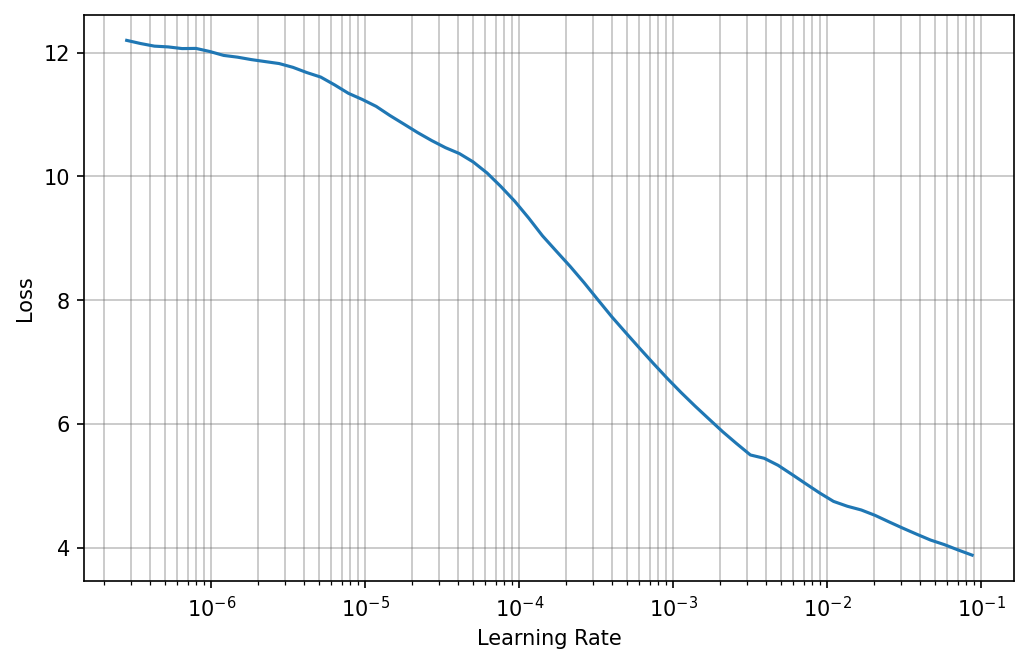

In [ ]:
plot_lr_finder(lrs, losses)

In [ ]:
FOUND_LR = 1e-3
optimizer = optim.Adam(model.parameters(), lr = FOUND_LR)

 ## Training a Convolutional Neural Network

In [ ]:
def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0
  model.train()
  for (x,y) in tqdm(iterator, desc = "Training", leave = False):
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    y_pred, _ = model(x)
    loss = criterion(y_pred,y)
    acc = calculate_accuracy(y_pred, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0
  model.eval()
  with torch.no_grad():
    for (x,y) in tqdm(iterator, desc = "Training", leave = False):
      x = x.to(device)
      y = y.to(device)
      y_pred, _ = model(x)
      loss = criterion(y_pred,y)
      acc = calculate_accuracy(y_pred, y)
      
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)


In [ ]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time/60)
  elapsed_secs = int(elapsed_time - (elapsed_mins*60))
  return elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 50
best_valid_loss = float('inf')
train_loss_l = []
test_loss_l =[]
train_acc_l = []
test_acc_l = []
for epoch in trange(EPOCHS,desc="Epochs"):
  start_time = time.monotonic()
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
  test_loss_l.append(test_loss)
  train_acc_l.append(train_acc) 
  test_acc_l.append(test_acc)


  # if valid_loss < best_valid_loss:
  #   best_valid_loss = valid_loss
  #   torch.save(model.state_dict(), 'tut3-model.pt')
  train_loss_l.append(train_loss)
  end_time = time.monotonic()
  epoch_mins, epoch_secs = epoch_time(start_time,end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}= {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  # print(f'\tValid Loss: {train_loss:.3f} | Valid Acc: {valid_acc*100:.2f}%\n')

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0= 3s
	Train Loss: 0.641 | Train Acc: 75.16%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0= 2s
	Train Loss: 0.753 | Train Acc: 72.09%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0= 2s
	Train Loss: 0.696 | Train Acc: 72.25%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0= 2s
	Train Loss: 0.629 | Train Acc: 76.93%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0= 2s
	Train Loss: 0.618 | Train Acc: 77.55%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0= 2s
	Train Loss: 0.660 | Train Acc: 76.12%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0= 2s
	Train Loss: 0.613 | Train Acc: 76.65%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0= 2s
	Train Loss: 0.610 | Train Acc: 76.61%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0= 2s
	Train Loss: 0.579 | Train Acc: 77.65%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0= 2s
	Train Loss: 0.615 | Train Acc: 77.94%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0= 2s
	Train Loss: 0.565 | Train Acc: 79.26%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0= 2s
	Train Loss: 0.565 | Train Acc: 79.04%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0= 2s
	Train Loss: 0.594 | Train Acc: 77.31%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0= 2s
	Train Loss: 0.510 | Train Acc: 81.82%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0= 2s
	Train Loss: 0.519 | Train Acc: 80.18%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0= 2s
	Train Loss: 0.555 | Train Acc: 79.28%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0= 2s
	Train Loss: 0.498 | Train Acc: 81.72%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0= 3s
	Train Loss: 0.497 | Train Acc: 82.42%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0= 2s
	Train Loss: 0.517 | Train Acc: 81.41%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0= 2s
	Train Loss: 0.455 | Train Acc: 82.82%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 0= 2s
	Train Loss: 0.478 | Train Acc: 81.67%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 0= 2s
	Train Loss: 0.556 | Train Acc: 79.43%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 0= 2s
	Train Loss: 0.485 | Train Acc: 82.01%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 0= 2s
	Train Loss: 0.451 | Train Acc: 83.31%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 0= 2s
	Train Loss: 0.523 | Train Acc: 80.80%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 0= 2s
	Train Loss: 0.500 | Train Acc: 82.23%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27 | Epoch Time: 0= 2s
	Train Loss: 0.447 | Train Acc: 83.00%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 0= 2s
	Train Loss: 0.476 | Train Acc: 82.33%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29 | Epoch Time: 0= 2s
	Train Loss: 0.487 | Train Acc: 81.72%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: 0= 2s
	Train Loss: 0.436 | Train Acc: 84.61%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 31 | Epoch Time: 0= 2s
	Train Loss: 0.420 | Train Acc: 84.49%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 32 | Epoch Time: 0= 3s
	Train Loss: 0.370 | Train Acc: 85.55%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 33 | Epoch Time: 0= 2s
	Train Loss: 0.393 | Train Acc: 85.37%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34 | Epoch Time: 0= 2s
	Train Loss: 0.395 | Train Acc: 85.70%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 35 | Epoch Time: 0= 2s
	Train Loss: 0.354 | Train Acc: 86.55%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 36 | Epoch Time: 0= 3s
	Train Loss: 0.372 | Train Acc: 86.07%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 37 | Epoch Time: 0= 2s
	Train Loss: 0.406 | Train Acc: 85.44%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 38 | Epoch Time: 0= 2s
	Train Loss: 0.502 | Train Acc: 81.58%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 39 | Epoch Time: 0= 2s
	Train Loss: 0.422 | Train Acc: 84.62%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40 | Epoch Time: 0= 2s
	Train Loss: 0.394 | Train Acc: 85.78%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 41 | Epoch Time: 0= 2s
	Train Loss: 0.428 | Train Acc: 84.10%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 42 | Epoch Time: 0= 2s
	Train Loss: 0.387 | Train Acc: 85.58%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 43 | Epoch Time: 0= 2s
	Train Loss: 0.394 | Train Acc: 85.44%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 44 | Epoch Time: 0= 2s
	Train Loss: 0.398 | Train Acc: 85.61%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 45 | Epoch Time: 0= 2s
	Train Loss: 0.375 | Train Acc: 86.41%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 46 | Epoch Time: 0= 2s
	Train Loss: 0.386 | Train Acc: 85.50%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 47 | Epoch Time: 0= 2s
	Train Loss: 0.375 | Train Acc: 85.82%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 48 | Epoch Time: 0= 2s
	Train Loss: 0.336 | Train Acc: 88.50%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 49 | Epoch Time: 0= 2s
	Train Loss: 0.412 | Train Acc: 85.26%


Training:   0%|          | 0/9 [00:00<?, ?it/s]

Training:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 50 | Epoch Time: 0= 2s
	Train Loss: 0.412 | Train Acc: 85.81%


 ## Evaluating a Convolutional Neural Network

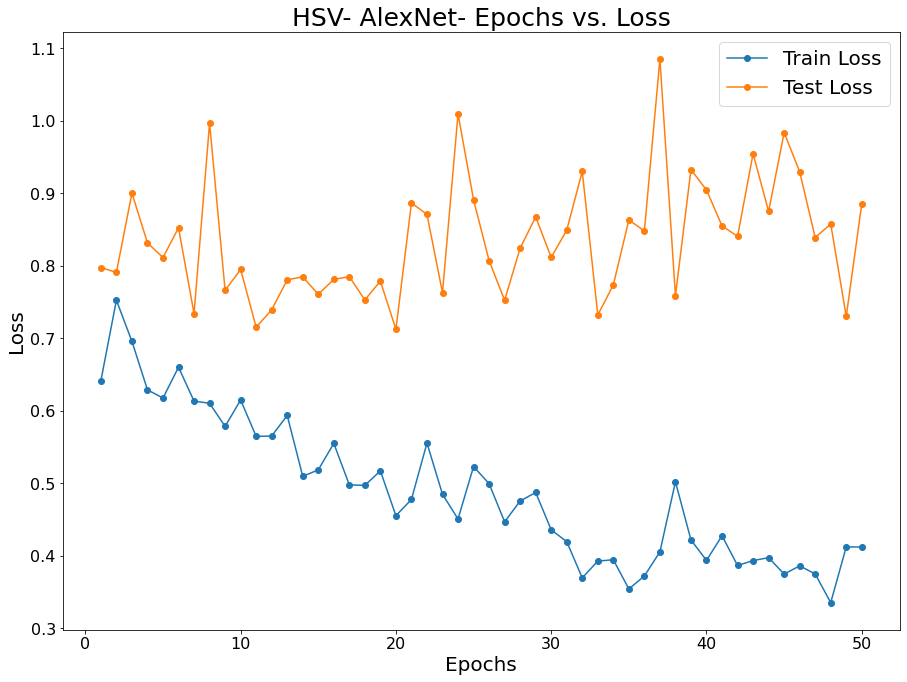

In [ ]:
# model.load_state_dict(torch.load('tut3-model.pt'))
# test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
# print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
# plt.savefig("Loss vs Epochs.jpg", dpi = 300, bbox_inches = 'tight')
# plt.savefig("Loss vs Epochs.pdf", dpi = 300, bbox_inches = 'tight')
from matplotlib import RcParams
myrcparams = RcParams({'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#EAEAF2',
          'axes.grid': True,
          'axes.labelcolor': '.15',
          'axes.linewidth': 0.0,
          'figure.facecolor': 'white',
          'font.family': ['serif'],
          'grid.color': 'white',
          'grid.linestyle': '--',
          'image.cmap': 'Greys',
          'legend.frameon': False,
          'legend.numpoints': 1,
          'legend.scatterpoints': 1,
          'lines.solid_capstyle': 'round',
          'text.color': '.15',
          'xtick.color': '.15',
          'xtick.direction': 'out',
          'xtick.major.size': 0.0,
          'xtick.minor.size': 0.0,
          'ytick.color': '.15',
          'ytick.direction': 'out',
          'ytick.major.size': 0.0,
          'ytick.minor.size': 0.0})

plt.style.library['seaborn-whitegrid']
RcParams.update(myrcparams)

fig, ax = plt.subplots(figsize =(15,11))

x = np.arange(1,len(train_loss_l)+1)

ax.plot(x, train_loss_l, '-o', label = "Train Loss")
ax.plot(x, test_loss_l, '-o', label = "Test Loss")

ax.set_xlabel("Epochs", fontsize = 20)
ax.set_ylabel("Loss", fontsize = 20)
ax.set_title('HSV- AlexNet- Epochs vs. Loss',fontsize = 25)

ax.tick_params(
    axis = 'both',
    labelsize = 16
)
ax.legend(fontsize = 20)
plt.savefig("HSV_AlexNet_Loss_vs_Epochs.jpg", dpi = 300, bbox_inches = 'tight')
plt.savefig("HSV_AlexNet_Loss_vs_Epochs.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()



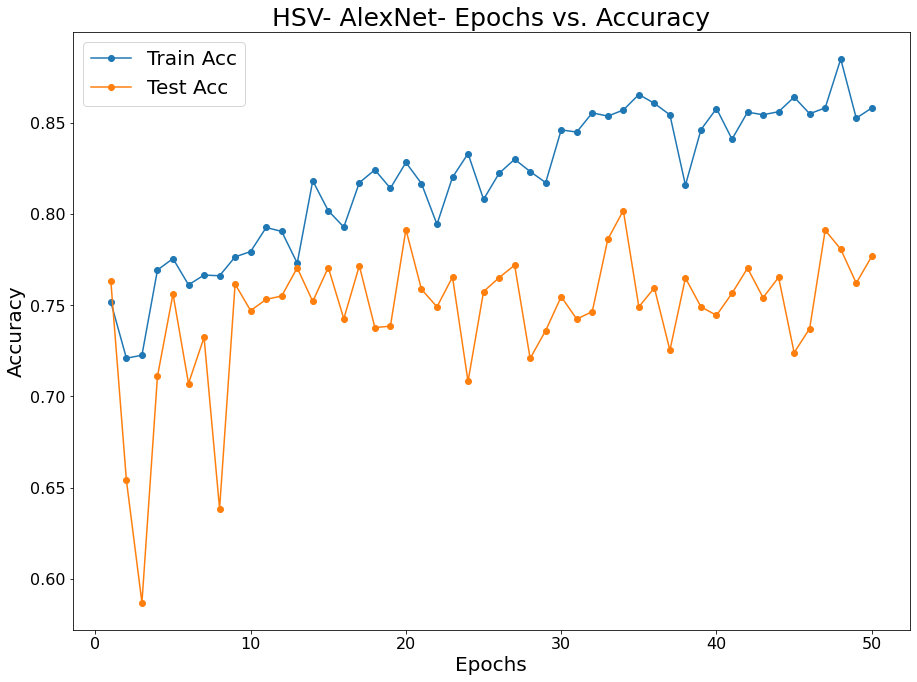

In [ ]:

fig, ax = plt.subplots(figsize =(15,11))

x = np.arange(1,len(train_loss_l)+1)

ax.plot(x, train_acc_l, '-o', label = "Train Acc")
ax.plot(x, test_acc_l, '-o', label = "Test Acc")

ax.set_xlabel("Epochs", fontsize = 20)
ax.set_ylabel("Accuracy", fontsize = 20)
ax.set_title('HSV- AlexNet- Epochs vs. Accuracy',fontsize = 25)

ax.tick_params(
    axis = 'both',
    labelsize = 16
)
ax.legend(fontsize = 20)
plt.savefig("HSV_AlexNet_Epochs_vs_Accuracy.jpg")
plt.savefig("HSV_AlexNet_Epochs_vs_Accuracy.pdf")
plt.show()



In [ ]:
def get_predictions(model, iterator, device):
  model.eval()
  images =[]
  labels=[]
  probs=[]
  with torch.no_grad():
    for (x,y) in iterator:
      x = x.to(device)
      y_pred, _ = model(x)
      y_prob = F.softmax(y_pred, dim = -1)
      images.append(x.cpu())
      labels.append(y.cpu())
      probs.append(y_prob.cpu())
  images = torch.cat(images, dim = 0)
  labels = torch.cat(labels, dim = 0)
  probs = torch.cat(probs, dim = 0)
  return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_iterator, device)

In [ ]:
pred_labels = torch.argmax(probs, 1)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def accuracy(output, target, top=(1,5)):
    """Computes the precision@k for the specified values of k"""
    #with torch.no_grad():
    maxk = max(top)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in top:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [ ]:
def calc_accuracy(model, dataloader):
    model.eval()
    model.cuda()    
    
    top1 = AverageMeter()
    top5 = AverageMeter()
    
    for idx, (inputs, labels) in enumerate(dataloader):
        
        inputs, labels = inputs.cuda().float(), labels.cuda().long()
        # obtain the outputs from the model
        outputs,h = model.forward(inputs)
        outputs  = torch.stack(list(outputs), dim=0)
        prec1, prec5 = accuracy(outputs, labels, top=(1,5))
        top1.update(prec1[0], inputs.size(0))
        top5.update(prec5[0], inputs.size(0))
        
    return top1 ,top5

In [ ]:
top1, top5 = calc_accuracy(model, test_loader)

In [ ]:
print(top1.avg)
print(top5.avg)

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
  fig = plt.figure(figsize = (10,10))
  ax = fig.add_subplot(1,1,1)
  cm = confusion_matrix(labels, pred_labels)
  cm = ConfusionMatrixDisplay(cm, display_labels = classes)
  cm.plot(values_format = 'd', ax = ax,cmap='Blues')
  plt.xticks(rotation = 20)
  plt.title('Confusion Matrix - AlexNet')
  plt.savefig('HSV_AlexNet_ConfusionMatrix.jpg')
  plt.savefig('HSV_AlexNet_ConfusionMatrix.pdf')

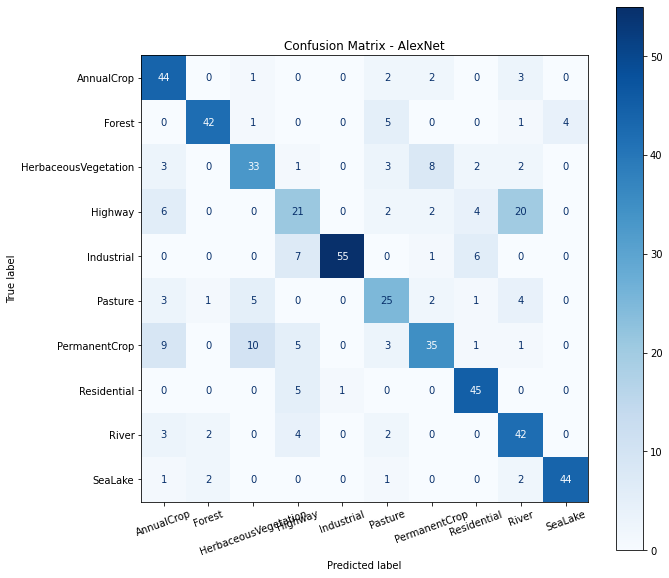

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)

In [ ]:
##Must print out top1.avg and top5.avg to get number
 x = {'HSV_AlexNet_Train_Acc':train_acc_l,'HSV_AlexNet_Test_Acc':test_acc_l, 'HSV_AlexNet_Train_Loss':train_loss_l,'HSV_AlexNet_Test_Loss':test_loss_l,'Top 1':72.693,'Top5':98.8889 }
 import pandas as pd
 DF = pd.DataFrame.from_dict(x)
 DF.to_csv('Accuracy.csv')
 download_files = ['HSV_AlexNet_Loss_vs_Epochs.jpg','HSV_AlexNet_Loss_vs_Epochs.pdf','HSV_AlexNet_Epochs_vs_Accuracy.jpg','HSV_AlexNet_Epochs_vs_Accuracy.pdf','HSV_AlexNet_ConfusionMatrix.jpg','HSV_AlexNet_ConfusionMatrix.pdf','HSV_AlexNet_LR_Finder.jpg','HSV_AlexNet_LR_Finder.pdf','Accuracy.csv']
 from google.colab import files
 for i in download_files:
   files.download(i)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
corrects = torch.eq(labels, pred_labels)

 ### Viewing our model's mistakes

In [ ]:
incorrect_examples = []
for image, label, prob, correct in zip(images, labels, probs, corrects):
  if not correct:
    incorrect_examples.append((image, label, prob))
incorrect_examples.sort(reverse=True, key = lambda x: torch.max(x[2], dim = 0).values)

In [ ]:
from matplotlib.cbook import normalize_kwargs
def plot_most_incorrect(incorrect, classes, n_images, normalize=True):
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize = (25,20))
  for i in range(rows*cols):
    ax = fig.add_subplot(rows,cols,i+1)
    image, true_label, probs = incorrect[i]
    image = image.permute(1,2,0)
    true_prob = probs[true_label]
    incorrect_prob, incorrect_label = torch.max(probs, dim=0)
    true_class = classes[true_label]
    incorrect_class = classes[incorrect_label]

    if normalize:
      image = normalize_image(image) 
    ax.imshow(image.cpu().numpy())
    ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n'
                  f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
    ax.axis('off')
  fig.subplots_adjust(hspace = .4)


In [ ]:
N_IMAGES = 36
plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

In [ ]:
def get_representations(model, iterator, device):
  model.eval()
  outputs = []
  intermediates = []
  labels = []
  with torch.no_grad():
    for (x,y) in tqdm(iterator):
      x = x.to(device) 
      y_pred, h = model(x) 
      outputs.append(y_pred.cpu())
      intermediates.append(h.cpu())
      labels.append(y) 
  outputs = torch.cat(outputs, dim = 0)
  intermediates = torch.cat(intermediates, dim = 0) 
  labels = torch.cat(labels, dim = 0) 
  return outputs, intermediates, labels

In [ ]:
outputs, intermediates, labels = get_representations(model, train_iterator, device)


 ### Visualizing our data in lower dimensions with PCA and t-SNE

In [ ]:
def get_pca(data, n_components = 2): 
  pca = decomposition.PCA()
  pca.n_components = n_components 
  pca_data = pca.fit_transform(data)
  return pca_data

In [ ]:
def plot_representations(data, labels, classes, n_images = None): 
  if n_images is not None:
    data = data[:n_images]
    labels = labels[:n_images]
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(111)
  scatter = ax.scatter(data[:,0],data[:,1],c=labels,cmap= 'tab10')
  handles, labels = scatter.legend_elements()
  ax.legend(handles = handles, labels= classes)
  ax.set_title('2D Representation of CIFAR10 Data')


In [ ]:
output_pca_data = get_pca(outputs) 
plot_representations(output_pca_data, labels, classes)

In [ ]:
intermediate_pca_data = get_pca(intermediates) 
plot_representations(intermediate_pca_data, labels, classes) 

In [ ]:
def get_tsne(data, n_components = 2, n_images = None):
  if n_images is not None:
    data = data[:n_images] 
  tsne = manifold.TSNE(n_components = n_components, random_state = 0) 
  tsne_data = tsne.fit_transform(data) 
  return tsne_data

In [ ]:
N_IMAGES = 5000
output_tsne_data = get_tsne(outputs, n_images = N_IMAGES) 
plot_representations(output_tsne_data, labels, classes, n_images = N_IMAGES) 


In [ ]:
intermediate_tsne_data = get_tsne(intermediates, n_images= N_IMAGES)
plot_representations(intermediate_tsne_data, labels, classes, n_images = N_IMAGES)